In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.center = self.conv_block(512, 1024)
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        center = self.center(F.max_pool2d(enc4, kernel_size=2, stride=2))
        dec4 = self.dec4(torch.cat([F.interpolate(center, scale_factor=2, mode='bilinear', align_corners=False), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, scale_factor=2, mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=False), enc1], dim=1))
        return self.final(dec1)

In [3]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()

        dice = 0
        for i in range(self.num_classes):
            input_flat = inputs[:, i].contiguous().view(-1)
            target_flat = targets[:, i].contiguous().view(-1)
            intersection = (input_flat * target_flat).sum()
            dice += (2. * intersection + self.smooth) / (input_flat.sum() + target_flat.sum() + self.smooth)
        
        return 1 - dice / self.num_classes


loading annotations into memory...
Done (t=23.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
Train dataset length: 43622
Validation dataset length: 3005
Inputs shape: torch.Size([2, 3, 1024, 1024])
Outputs shape: torch.Size([2, 13, 1024, 1024])
Predicted shape: torch.Size([2, 1024, 1024])
Masks shape: torch.Size([2, 1024, 1024])


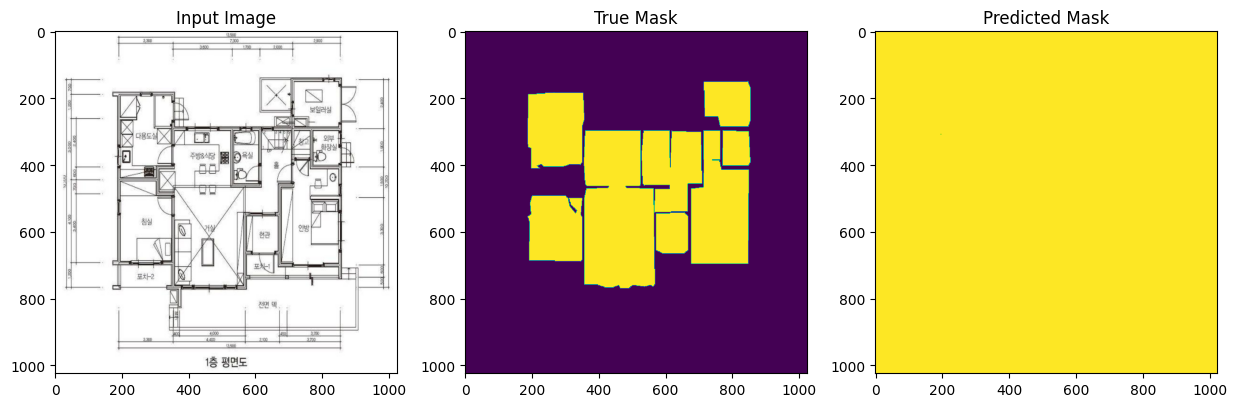

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 21811/21811 [2:48:14<00:00,  2.16it/s]


Epoch 1/50, Loss: 0.0213
Validation Loss: 0.0084, Accuracy: 98.19%


Epoch 2/50:  15%|█████████▌                                                      | 3262/21811 [26:34<2:31:06,  2.05it/s]


KeyboardInterrupt: 

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

class Config:
    def __init__(self):
        self.dataloader_num_workers = 4
        self.batch_size = 2
        self.image_size = 1024
        self.base_lr = 0.001
        self.num_epochs = 50
        self.eval_period = 1
        self.num_classes = 13

cfg = Config()

class COCOSegmentationDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        if len(anns) == 0:
            return self.__getitem__((index + 1) % len(self.ids))

        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        mask = Image.new('L', (img.width, img.height), 0)
        for ann in anns:
            if 'segmentation' in ann and ann['segmentation']:
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((len(seg) // 2, 2))
                    ImageDraw.Draw(mask).polygon([tuple(p) for p in poly], outline=1, fill=1)

        if self.transform is not None:
            img = self.transform(img)
            mask = mask.resize((cfg.image_size, cfg.image_size), Image.NEAREST)
            mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

    def __len__(self):
        return len(self.ids)

transform = transforms.Compose([
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.ToTensor()
])

train_dataset = COCOSegmentationDataset(root='./dataset/train/images', annFile='./dataset/train/train_annotations.coco.json', transform=transform)
val_dataset = COCOSegmentationDataset(root='./dataset/valid/images', annFile='./dataset/valid/valid_annotations.coco.json', transform=transform)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

def create_dataloaders(train_dataset, val_dataset, batch_size, num_workers):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, cfg.batch_size, cfg.dataloader_num_workers)

model = UNet(num_classes=cfg.num_classes)
criterion = DiceLoss(num_classes=cfg.num_classes)
optimizer = optim.Adam(model.parameters(), lr=cfg.base_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def visualize_sample(data_loader):
    model.eval()
    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            print(f"Inputs shape: {inputs.shape}")
            print(f"Outputs shape: {outputs.shape}")
            print(f"Predicted shape: {predicted.shape}")
            print(f"Masks shape: {masks.shape}")

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(inputs[0].cpu().permute(1, 2, 0))
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[0].cpu())
            plt.title('True Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted[0].cpu())
            plt.title('Predicted Mask')

            plt.show()
            break

# 검증 세트에서 샘플 시각화
visualize_sample(val_loader)

for epoch in range(cfg.num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}"):
        inputs, masks = inputs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    print(f"Epoch {epoch+1}/{cfg.num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    if (epoch + 1) % cfg.eval_period == 0:
        torch.save(model.state_dict(), f'./output/unet_coco_epoch{epoch+1}.pth')

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += masks.numel()
                correct += (predicted == masks).sum().item()

        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), './output/unet_coco_final.pth')
